In [1]:
import os, sys, glob
from datetime import datetime
sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')

from mi.instrument.kut.ek60.ooicore.zplsc_b import *
from concat_raw import *

data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
fname1 = glob.glob(os.path.join(data_path,'OOI-D20150910-T*.raw'))
fname2 = glob.glob(os.path.join(data_path,'OOI-D20170910-T*.raw'))
fname1 = fname1[0]
fname2 = fname2[0]

In [2]:
%matplotlib inline

In [3]:
particle_data1, data_times1, power_data_dict1, freq1, bin_size1, config_header1, config_transducer1 = parse_echogram_file(fname1)

2017-09-14 13:46:00,093 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150910-T000000.raw'


In [602]:
particle_data2, data_times2, power_data_dict2, freq2, bin_size2, config_header2, config_transducer2 = parse_echogram_file(fname2)

2017-09-16 22:04:34,916 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20170910-T000000.raw'


In [5]:
power_data_dict1[1].shape

(1046, 28725)

In [6]:
power_data_dict2[1].shape

(1072, 5923)

## Uncompensated echogram for 20150910

### 120 kHz

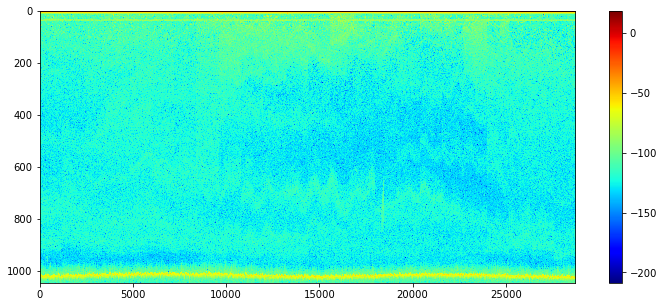

In [7]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[1],aspect='auto',cmap='jet')
plt.colorbar()

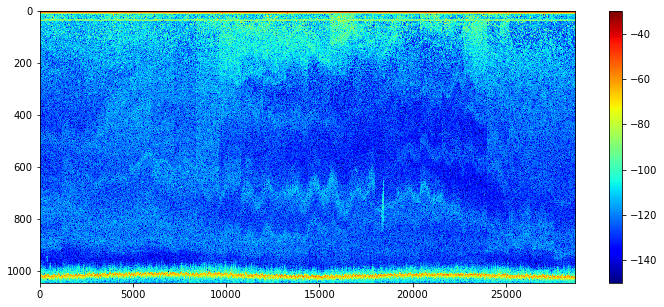

In [8]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[1],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

### 200 kHz

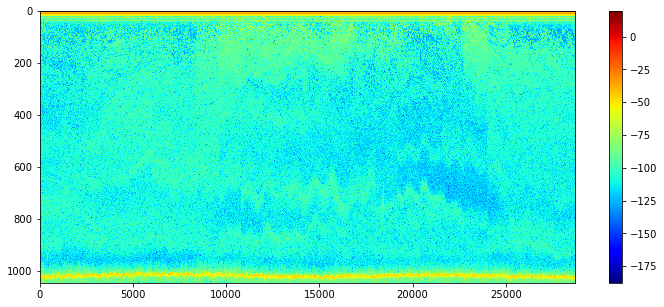

In [9]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[2],aspect='auto',cmap='jet')
plt.colorbar()

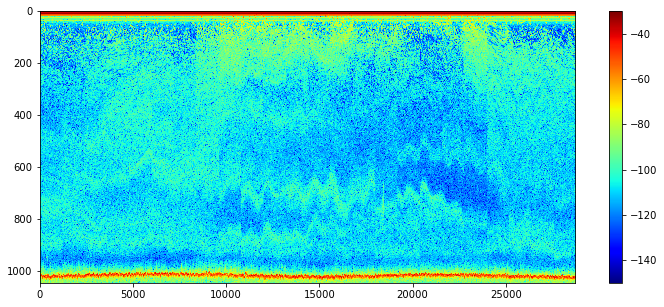

In [10]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[2],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

## Uncompensated echogram for 20170910

### 120 kHz

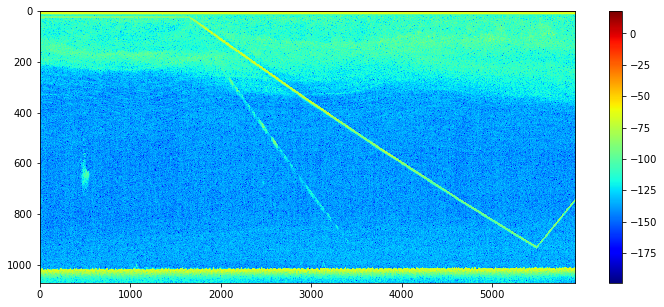

In [11]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[1],aspect='auto',cmap='jet')
plt.colorbar()

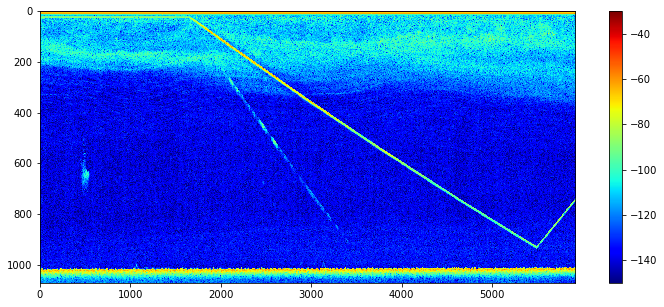

In [12]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[1],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

### 200 kHz

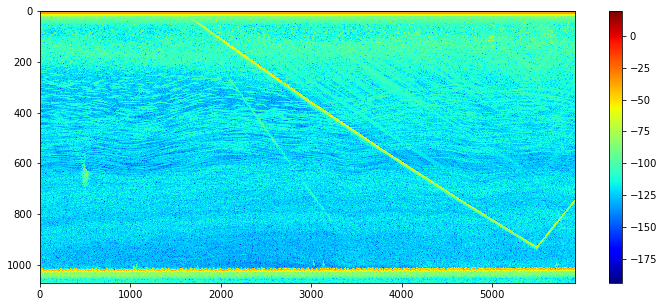

In [13]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[2],aspect='auto',cmap='jet')
plt.colorbar()

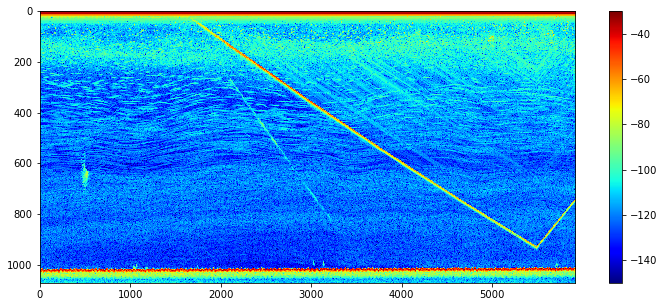

In [14]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[2],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

# Test implementing De Robertis and Higginbottom 2007 algorithm

In [15]:
power_data_dict1[1].shape

(1046, 28725)

In [16]:
power_data_dict2[1].shape

(1072, 5923)

In [17]:
(bin_size1,bin_size2)

(array([ 0.19121777], dtype=float32), array([ 0.19121777], dtype=float32))

In [66]:
power_data_dict = power_data_dict1
particle_data = particle_data1
config_header = config_header1
config_transducer = config_transducer1

In [76]:
M = 40   # average over M pings
depth_bin_range = 10   # average over depth_bin_range [m]
N1 = int(np.floor(depth_bin_range/bin_size1))
N2 = int(np.floor(depth_bin_range/bin_size2))

In [77]:
tvgCorrectionFactor = 2   # default is to apply TVG correction with offset of 2
                          # note this factor is important in TVG compensation
                          # and therefore in how power_bin is obtained as well

# Average uncompensated power over M pings and N depth bins
depth_bin_num = int(np.floor((power_data_dict[1].shape[0]-tvgCorrectionFactor)/N1))
ping_bin_num = int(np.floor(power_data_dict[1].shape[1]/M))
power_bin = np.empty([depth_bin_num,ping_bin_num])
for iD in range(depth_bin_num):
    for iP in range(ping_bin_num):
        depth_idx = np.arange(N1)+N1*iD+tvgCorrectionFactor  # match the 2-sample offset
        ping_idx = np.arange(M)+M*iP
        power_bin[iD,iP] = np.mean(10**(power_data_dict[1][np.ix_(depth_idx,ping_idx)]/10))

# Noise = minimum value for each averaged ping
noise = np.min(power_bin,0)

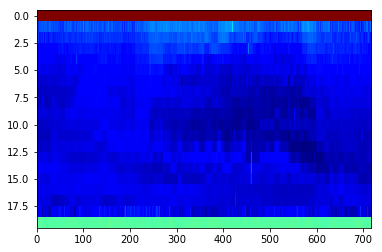

In [78]:
plt.imshow(10*np.log10(power_bin),aspect='auto',cmap='jet')

In [79]:
power_bin.shape

(20, 718)

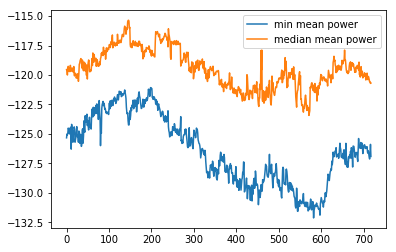

In [81]:
plt.plot(10*np.log10(np.min(power_bin,0)),label='min mean power')
plt.plot(10*np.log10(np.median(power_bin,0)),label='median mean power')
plt.legend()

## Function for noise estimation

In [157]:
def get_noise(power_data,depth_bin_size,ping_bin_range,depth_bin_range,tvgCorrectionFactor=2):
    '''
    INPUT:
        ping_bin_range        average over M pings
        depth_bin_range       average over depth_bin_range [m]
        tvgCorrectionFactor   default (=2) is to apply TVG correction with offset of 2 samples
                              note this factor is important in TVG compensation
                              and therefore in how power_bin is obtained as well
    OUTPUT:
        minimum value for bins of averaged ping
    '''
    N = int(np.floor(depth_bin_range/depth_bin_size))
    
    # Average uncompensated power over M pings and N depth bins
    depth_bin_num = int(np.floor((power_data.shape[0]-tvgCorrectionFactor)/N))
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    power_bin = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N)+N*iD+tvgCorrectionFactor  # match the 2-sample offset
            ping_idx = np.arange(ping_bin_range)+ping_bin_range*iP
            power_bin[iD,iP] = np.mean(10**(power_data[np.ix_(depth_idx,ping_idx)]/10))

    # Noise = minimum value for each averaged ping
    return np.min(power_bin,0)

In [125]:
noise_M40 = get_noise(power_data_dict1[1],bin_size1,40,10)

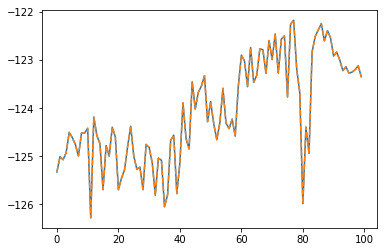

In [126]:
# Check function is doing the right thing
plt.plot(10*np.log10(np.min(power_bin,0))[:100])
plt.plot(10*np.log10(noise_M40)[:100],'--')

# Check influence of ping bin size

### 20150910 120kHz data

In [166]:
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict1[1],bin_size1,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

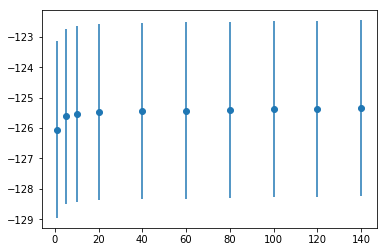

In [167]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

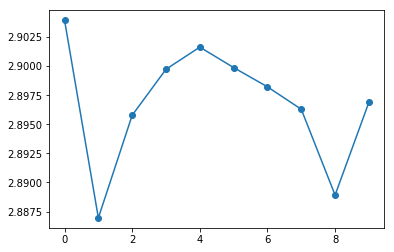

In [168]:
plt.plot(noise_stat[:,1],marker='o')

### Take only a subset of data to check if the high and persistent standard deviation of noise power is resulted from including way too many pings/averaged pings

In [162]:
power_data_dict1_sub = power_data_dict1[1][:,:5923]
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict1_sub,bin_size1,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

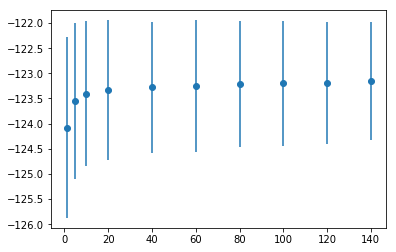

In [163]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

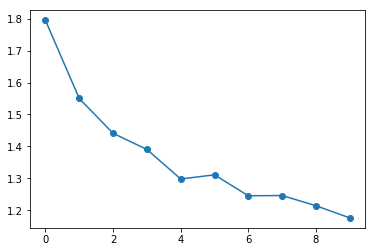

In [165]:
plt.plot(noise_stat[:,1],marker='o')

### 20170910 120kHz data

In [323]:
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict2[1],bin_size2,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

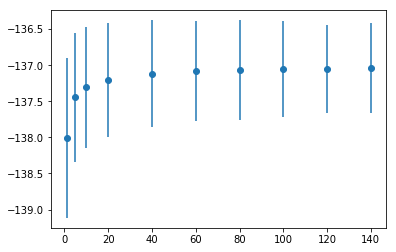

In [324]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

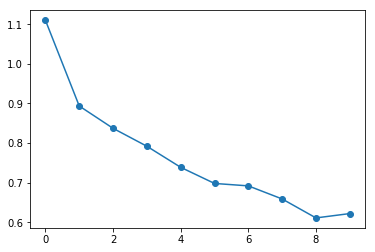

In [325]:
plt.plot(noise_stat[:,1],marker='o')

### The trend of decreasing standard deviation of noise estimate with increasing number of pings averaged shown in Fig.3 of De Robertis and Higginbottom 2007 is only observed when the number of averaged pings included in total are moderate. When there are too many averaged pings, such as in the 20150910 case, the trend is not obvious.

# Noise estimate with TVG and absorption compensation

### 20150910 120 kHz data

In [184]:
n = 0 # firs freq = 120kHz in unpacked format

f = cal_params[n]['frequency']
c = cal_params[n]['soundvelocity']
t = cal_params[n]['sampleinterval']
alpha = cal_params[n]['absorptioncoefficient']
G = cal_params[n]['gain']
phi = cal_params[n]['equivalentbeamangle']
pt = cal_params[n]['transmitpower']
tau = cal_params[n]['pulselength']

dR = c*t/2   # sample thickness
#wvlen = c/f  # wavelength

# determine number of samples in array
pSize = power_data_dict1[n+1].shape   # size(data.pings(n).power);
# create range vector (in m)
range_vec = np.arange(pSize[0]) * dR  # no range correction needed for predicting noise
TVG = np.empty(range_vec.shape)
TVG[range_vec!=0] =  20*np.log10(range_vec[range_vec!=0])  # TVG = real(20*log10(range_vec));
TVG[range_vec==0] = 0

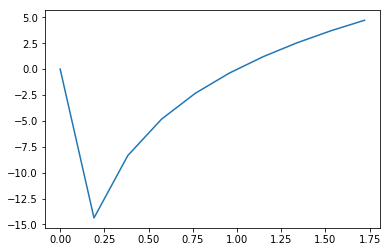

In [187]:
plt.plot(range_vec[:10],TVG[:10])

# Look into differences between the 2 noise subtraction approaches

In [402]:
power_data = power_data_dict1[1]
cal = cal_params[0]

# Get cal params
f = cal['frequency']
c = cal['soundvelocity']
t = cal['sampleinterval']
alpha = cal['absorptioncoefficient']
G = cal['gain']
phi = cal['equivalentbeamangle']
pt = cal['transmitpower']
tau = cal['pulselength']

# key derived params
dR = c*t/2   # sample thickness
wvlen = c/f  # wavelength

# Calc gains
CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

# calculate Sa Correction
idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
Sac = 2 * cal['sacorrectiontable'][idx]

# Get TVG
range_vec = np.arange(power_data.shape[0]) * dR
rangeCorrected = range_vec - (tvg_correction_factor * dR)
rangeCorrected[rangeCorrected<0] = 0

TVG = np.empty(rangeCorrected.shape)
TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
TVG[rangeCorrected==0] = 0

# Get absorption
ABS = 2*alpha*rangeCorrected

In [405]:
noise_est = get_noise(power_data,bin_size1,ping_bin_range=40,depth_bin_range=10)

## Compare ping 1000

In [406]:
iP = 25
#ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range # verified ping 1000 is in iP=25 bin
ping_idx = 1000
tmp_lin = 10**(power_data[:,ping_idx]/10) -noise_est[iP]

Comparing the power data from ping 1000 with the estimated noise in this bin.

First in the log domain:

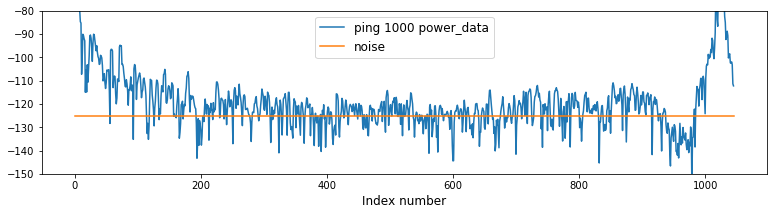

In [503]:
plt.figure(figsize=(13,3))
plt.plot(power_data[:,ping_idx],label='ping 1000 power_data')
plt.plot([0,power_data.shape[0]],np.array([10*np.log10(noise_est[iP])]*2),label='noise')
plt.ylim([-150,-80])
plt.legend(fontsize=12)
plt.xlabel('Index number',fontsize=12)

And then in the linear domain:

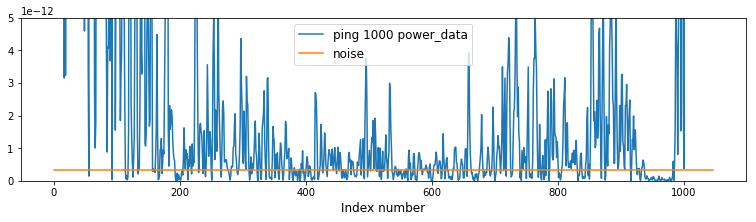

In [501]:
plt.figure(figsize=(13,3))
plt.plot(10**(power_data[:,ping_idx]/10),label='ping 1000 power_data')
plt.plot([0,power_data.shape[0]],np.array([noise_est[iP]]*2),label='noise')
plt.ylim([0,5E-12])
plt.legend(fontsize=12)
plt.xlabel('Index number',fontsize=12)

Now compensate both the power data and noise estimate by TVG and ABS (absorption). Make compensation in two ways:
    1. subtract nosie from power data in linear domain before TVG/ABS compensation

In [447]:
subtract1 = 10**(power_data[:,ping_idx]/10) - noise_est[iP]
subtract1_comp = 10*np.log10(subtract1)+TVG+ABS   # method 1: subtract before compensate

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


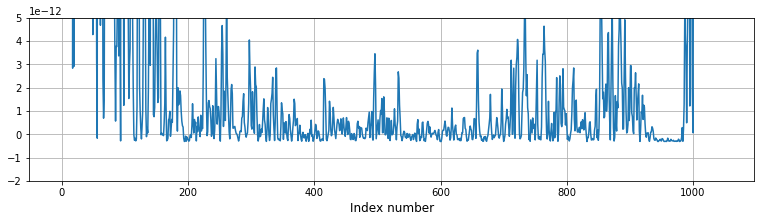

In [499]:
plt.figure(figsize=(13,3))
plt.plot(subtract1)
plt.ylim([-2E-12,5E-12])
plt.grid()
plt.xlabel('Index number',fontsize=12)

    2. compensate TVG and ABS separately first in the log domain, and subtract in linear domain

In [ ]:
power_data_comp = power_data[:,ping_idx]+TVG+ABS  # compensation first (log domain)
noise_comp = 10*np.log10(noise_est[iP])+TVG+ABS   # compensation first (log domain)
subtract2 = 10**(power_data_comp/10)-10**(noise_comp/10)
subtract2_comp = 10*np.log10(subtract2)           # method 2: compensate before substract

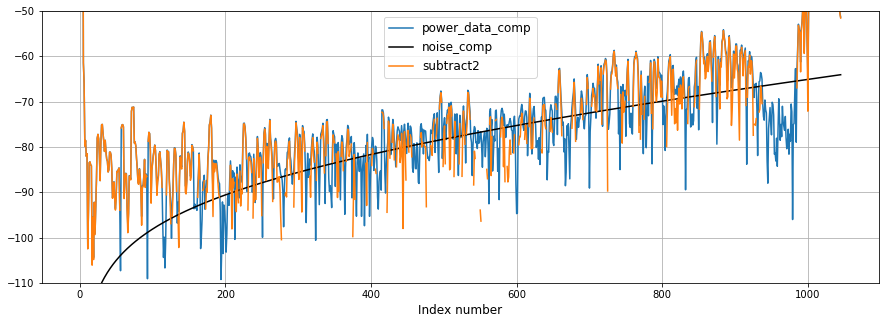

In [498]:
plt.figure(figsize=(15,5))
plt.plot(power_data_comp,label='power_data_comp')
plt.plot(noise_comp,'k',label='noise_comp')
plt.plot(subtract2_comp,label='subtract2')
plt.ylim([-110,-50])
plt.grid()
plt.legend(fontsize=12)
plt.xlabel('Index number',fontsize=12)

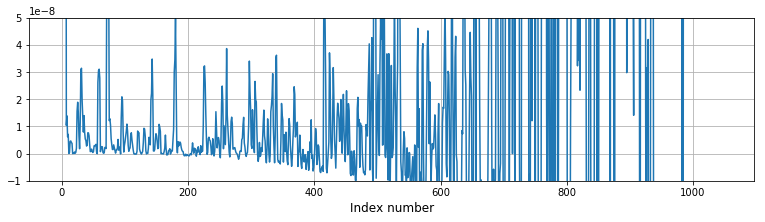

In [497]:
plt.figure(figsize=(13,3))
plt.plot(subtract2)
plt.ylim([-1E-8,5E-8])
plt.grid()
plt.xlabel('Index number',fontsize=12)

Check if the indices of eliminated points are the same between methods 1 and 2.

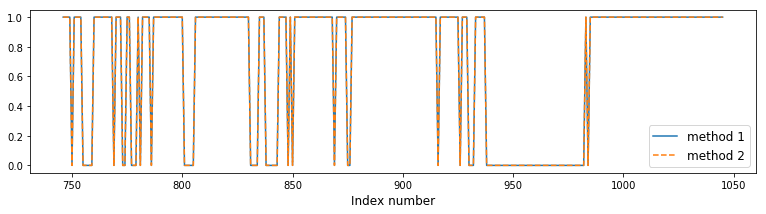

In [495]:
idx1 = subtract1>0
idx2 = subtract2>0
idx_x = np.arange(power_data.shape[0])[-300:]
plt.figure(figsize=(13,3))
plt.plot(idx_x,idx1[-300:],label='method 1')
plt.plot(idx_x,idx2[-300:],'--',label='method 2')
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

Check if the compensated values are the same between methods 1 and 2.

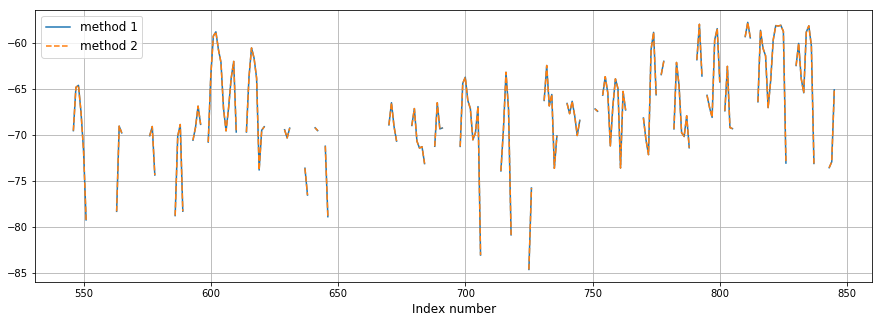

In [523]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],subtract1_comp[-500:-200],label='method 1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],subtract2_comp[-500:-200],'--',label='method 2')
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

## Compare ping 5000

In [519]:
iP = 125
#ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range # verified ping 5000 is in iP=125 bin
ping_idx = 5000
tmp_lin = 10**(power_data[:,ping_idx]/10) -noise_est[iP]

In [520]:
subtract1 = 10**(power_data[:,ping_idx]/10) - noise_est[iP]
subtract1_comp = 10*np.log10(subtract1)+TVG+ABS   # method 1: subtract before compensate
power_data_comp = power_data[:,ping_idx]+TVG+ABS  # compensation first (log domain)
noise_comp = 10*np.log10(noise_est[iP])+TVG+ABS   # compensation first (log domain)
subtract2 = 10**(power_data_comp/10)-10**(noise_comp/10)
subtract2_comp = 10*np.log10(subtract2)           # method 2: compensate before substract

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


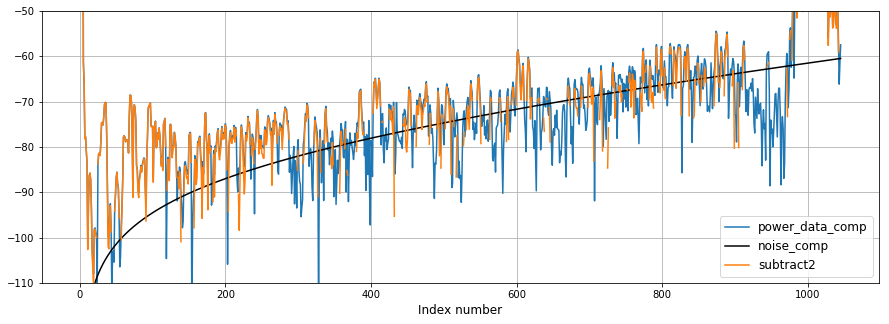

In [525]:
plt.figure(figsize=(15,5))
plt.plot(power_data_comp,label='power_data_comp')
plt.plot(noise_comp,'k',label='noise_comp')
plt.plot(subtract2_comp,label='subtract2')
plt.ylim([-110,-50])
plt.grid()
plt.legend(fontsize=12)
plt.xlabel('Index number',fontsize=12)

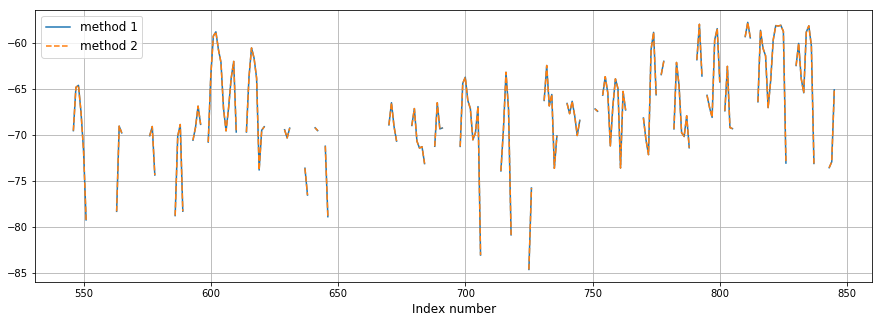

In [522]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],subtract1_comp[-500:-200],label='method 1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],subtract2_comp[-500:-200],'--',label='method 2')
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

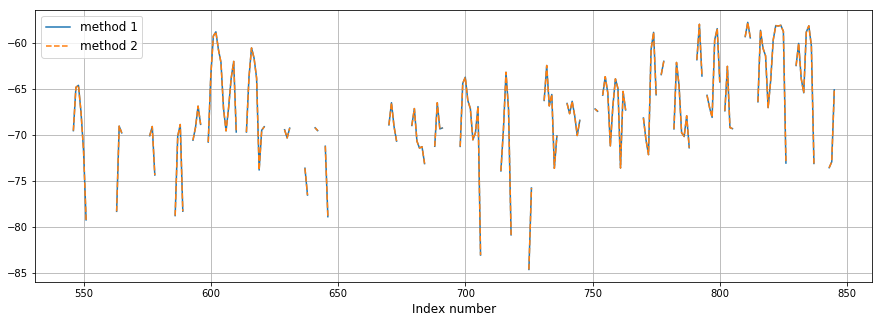

In [533]:
ping_idx = 5000
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr1[-500:-200,ping_idx],label='method 1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr2[-500:-200,ping_idx],'--',label='method 2')
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

## Check if method 1 and 2 are equivalent in the bulk processing algorithm

In [524]:
power_data = power_data_dict1[1]
cal = cal_params[0]

# Get cal params
f = cal['frequency']
c = cal['soundvelocity']
t = cal['sampleinterval']
alpha = cal['absorptioncoefficient']
G = cal['gain']
phi = cal['equivalentbeamangle']
pt = cal['transmitpower']
tau = cal['pulselength']

# key derived params
dR = c*t/2   # sample thickness
wvlen = c/f  # wavelength

# Calc gains
CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

# calculate Sa Correction
idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
Sac = 2 * cal['sacorrectiontable'][idx]

# Get TVG
range_vec = np.arange(power_data.shape[0]) * dR
rangeCorrected = range_vec - (tvg_correction_factor * dR)
rangeCorrected[rangeCorrected<0] = 0

TVG = np.empty(rangeCorrected.shape)
TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
TVG[rangeCorrected==0] = 0

# Get absorption
ABS = 2*alpha*rangeCorrected

In [549]:
# Compensate measurement for noise and corrected for transmission loss
# also estimate Sv_noise component for subsequent SNR check

# Method 1: subtract before compensate
ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
Sv_corr1 = np.empty(power_data.shape)   # log domain corrected Sv
Sv_noise = np.empty(power_data.shape)  # Sv_noise
for iP in range(ping_bin_num):
    ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
    subtract1 = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
    subtract1_comp = (10*np.log10(subtract1.T)+TVG+ABS).T   # method 1: subtract before compensate
    Sv_corr1[:,ping_idx] = subtract1_comp
    #tmp = np.empty(tmp_lin.shape)
    #tmp[tmp_lin>0] = 10*np.log10(tmp_lin[tmp_lin>0])
    #tmp[tmp_lin<=0] = -999
    #Sv_corr1[:,ping_idx] = (tmp.T +TVG +ABS -CSv -Sac).T
    Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG +ABS]*ping_bin_range).T

Sv_raw = (power_data.T+TVG+ABS).T  # compensation first (log domain)
subtract2 = 10**(power_data_comp/10)-10**(Sv_noise/10)
Sv_corr2 = 10*np.log10(subtract2)           # method 2: compensate before substract

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


Check if methods 1 and 2 corresponds to each other:

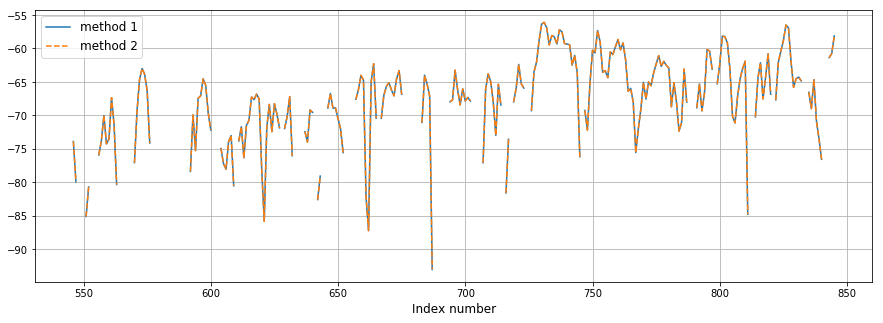

In [550]:
ping_idx = 1500
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr1[-500:-200,ping_idx],label='method 1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr2[-500:-200,ping_idx],'--',label='method 2')
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

Check data before subtraction in method 2:

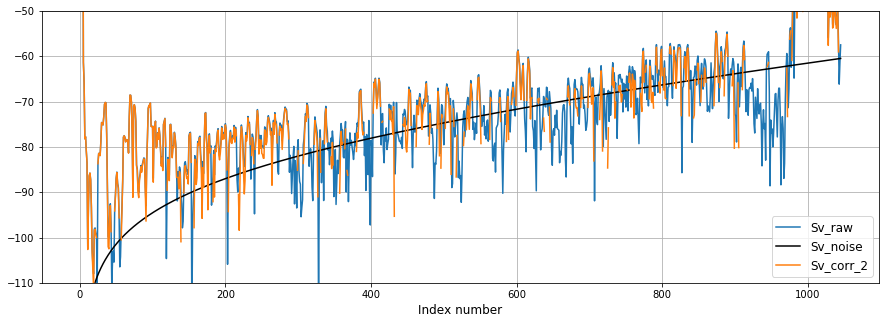

In [551]:
ping_idx = 5000
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0]),Sv_raw[:,ping_idx],label='Sv_raw')
plt.plot(np.arange(power_data.shape[0]),Sv_noise[:,ping_idx],'k',label='Sv_noise')
plt.plot(np.arange(power_data.shape[0]),Sv_corr2[:,ping_idx],label='Sv_corr_2')
plt.ylim([-110,-50])
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

Check all data in two dimensions

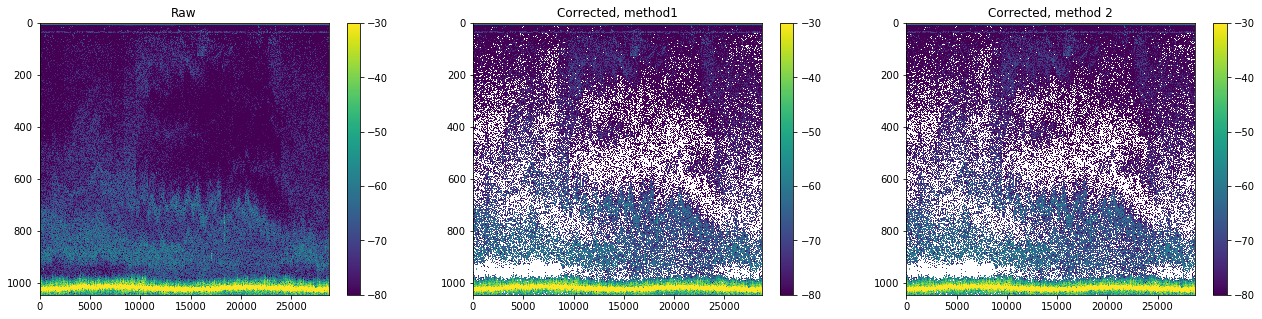

In [554]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr1,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr2,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

The above figure shows that the two compensation methods produce the same results.

Now check what would happen if force negative elements after subtraction to 0 before converting to log domain.

In [578]:
# Compensate measurement for noise and corrected for transmission loss
# also estimate Sv_noise component for subsequent SNR check

# Method 1: subtract before compensate
ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
Sv_corr1 = np.empty(power_data.shape)   # log domain corrected Sv
Sv_noise = np.empty(power_data.shape)  # Sv_noise
for iP in range(ping_bin_num):
    ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
    subtract1 = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
    tmp1 = np.empty(subtract1.shape)
    tmp1[subtract1>0] = 10*np.log10(subtract1[subtract1>0])
    tmp1[subtract1<=0] = -999
    tmp1 = (tmp1.T +TVG+ABS).T
    Sv_corr1[:,ping_idx] = tmp1
    Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG +ABS]*ping_bin_range).T

# Method 2: compensate before subtract
Sv_raw = (power_data.T+TVG+ABS).T  # compensation first (log domain)
subtract2 = 10**(power_data_comp/10)-10**(Sv_noise/10)
tmp2 = np.empty(subtract2.shape)
tmp2[subtract2>0] = 10*np.log10(subtract2[subtract2>0])
tmp2[subtract2<=0] = -999
Sv_corr2 = tmp2

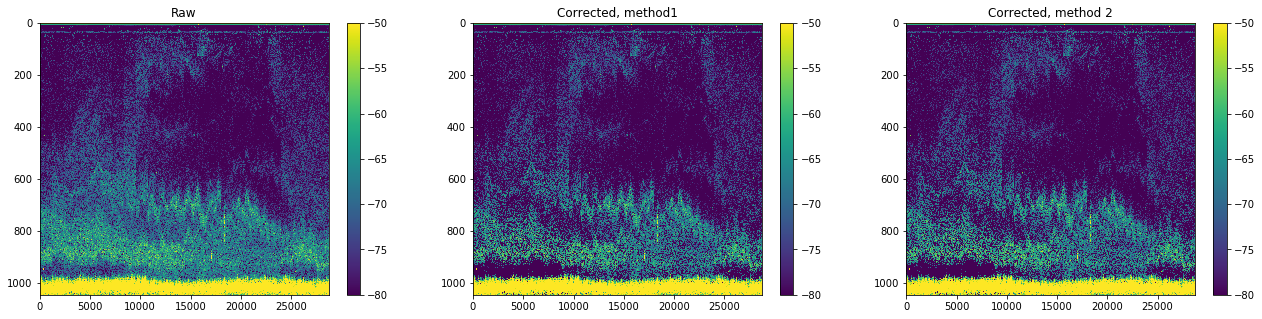

In [581]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr1,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr2,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

The bulk processing results from methods 1 and 2 corresponds to each other.

Check a few individual pings to see if this is true.

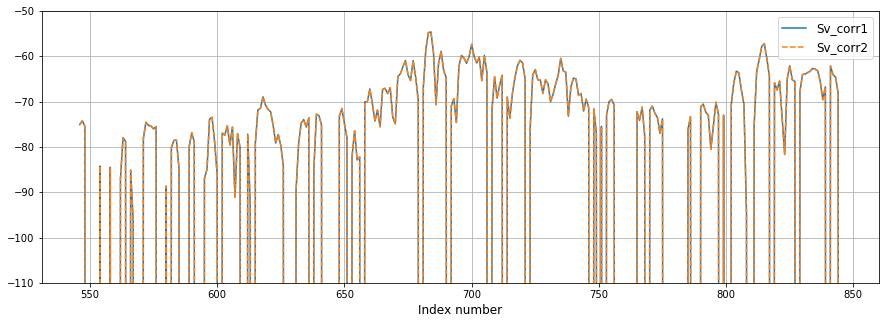

In [586]:
ping_idx = 15000
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr1[-500:-200,ping_idx],label='Sv_corr1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr2[-500:-200,ping_idx],'--',label='Sv_corr2')
plt.ylim([-110,-50])
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

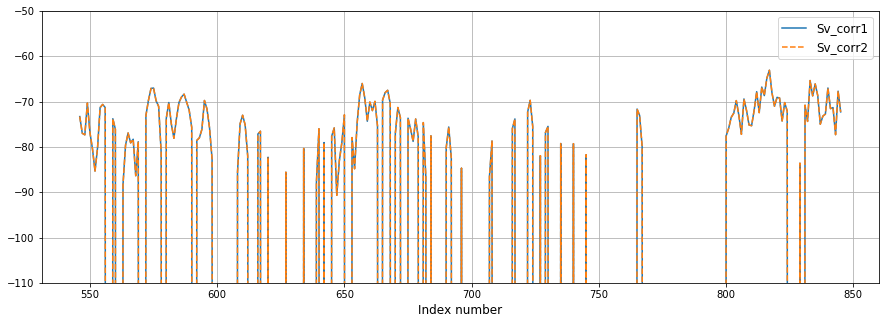

In [588]:
ping_idx = 25000
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr1[-500:-200,ping_idx],label='Sv_corr1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr2[-500:-200,ping_idx],'--',label='Sv_corr2')
plt.ylim([-110,-50])
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

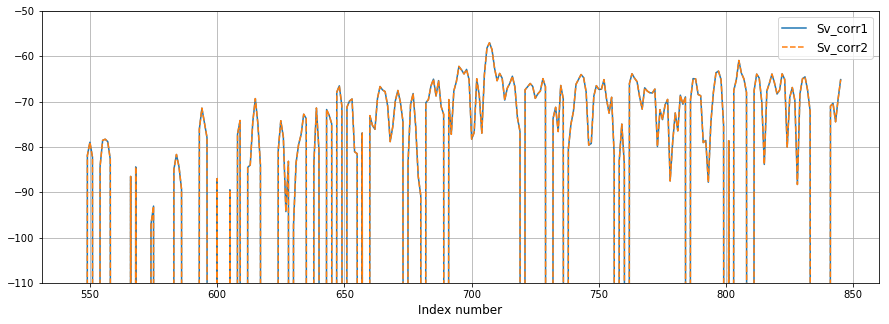

In [589]:
ping_idx = 16789
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr1[-500:-200,ping_idx],label='Sv_corr1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr2[-500:-200,ping_idx],'--',label='Sv_corr2')
plt.ylim([-110,-50])
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

Looks good. Now make it a function and check results.

## Function for noise removal and TVG + absorption compensation

In [607]:
def remove_noise(power_data,cal,noise_est,ping_bin_range=40,tvg_correction_factor=2):
    '''
    fn      sequence number of that particular freq in power_data
            corresponds to index fn-1 in cal_params
    tvg_correction_factor   default(=2) for converting power_data to Sv
    '''

    # Get cal params
    f = cal['frequency']
    c = cal['soundvelocity']
    t = cal['sampleinterval']
    alpha = cal['absorptioncoefficient']
    G = cal['gain']
    phi = cal['equivalentbeamangle']
    pt = cal['transmitpower']
    tau = cal['pulselength']

    # key derived params
    dR = c*t/2   # sample thickness
    wvlen = c/f  # wavelength

    # Calc gains
    CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

    # calculate Sa Correction
    idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
    Sac = 2 * cal['sacorrectiontable'][idx]

    # Get TVG
    range_vec = np.arange(power_data.shape[0]) * dR
    rangeCorrected = range_vec - (tvg_correction_factor * dR)
    rangeCorrected[rangeCorrected<0] = 0

    TVG = np.empty(rangeCorrected.shape)
    TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
    TVG[rangeCorrected==0] = 0

    # Get absorption
    ABS = 2*alpha*rangeCorrected

    # Compensate measurement for noise and corrected for transmission loss
    # also estimate Sv_noise component for subsequent SNR check

    # Method 1: subtract before compensate
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    Sv_corr1 = np.empty(power_data.shape)   # log domain corrected Sv
    Sv_noise = np.empty(power_data.shape)  # Sv_noise
    for iP in range(ping_bin_num):
        ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
        subtract1 = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
        tmp1 = np.empty(subtract1.shape)
        tmp1[subtract1>0] = 10*np.log10(subtract1[subtract1>0])
        tmp1[subtract1<=0] = -999
        tmp1 = (tmp1.T +TVG+ABS).T
        Sv_corr1[:,ping_idx] = tmp1
        Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG +ABS]*ping_bin_range).T

    # Method 2: compensate before subtract
    Sv_raw = (power_data.T+TVG+ABS).T  # compensation first (log domain)
    subtract2 = 10**(Sv_raw/10)-10**(Sv_noise/10)
    tmp2 = np.empty(subtract2.shape)
    tmp2[subtract2>0] = 10*np.log10(subtract2[subtract2>0])
    tmp2[subtract2<=0] = -999
    Sv_corr2 = tmp2
    
    # Output
    return Sv_raw,Sv_noise,Sv_corr1,Sv_corr2
    

In [592]:
cal_params = get_cal_params(power_data_dict1,particle_data1,config_header1,config_transducer1)
noise_est = get_noise(power_data_dict1[1],bin_size1,ping_bin_range=40,depth_bin_range=10)
Sv_raw,Sv_noise,Sv_corr_method1,Sv_corr_method2 = remove_noise(power_data_dict1[1],cal_params[0],noise_est,ping_bin_range=40,tvg_correction_factor=2)

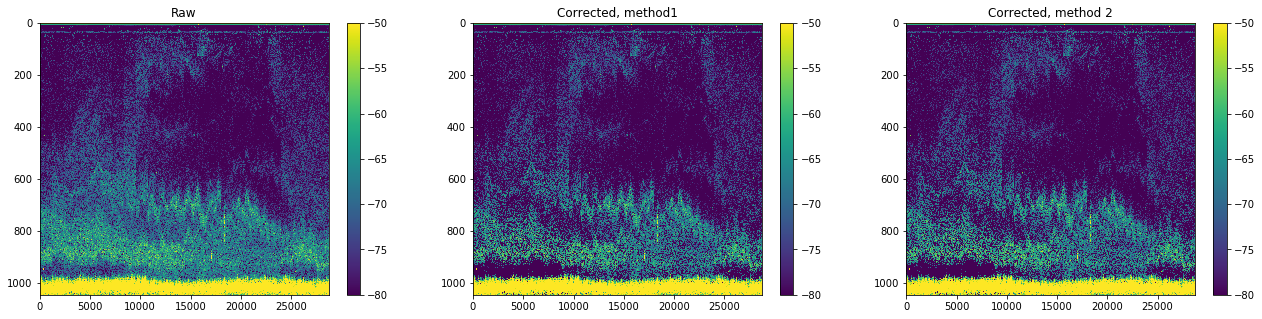

In [593]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_method1,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr_method2,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

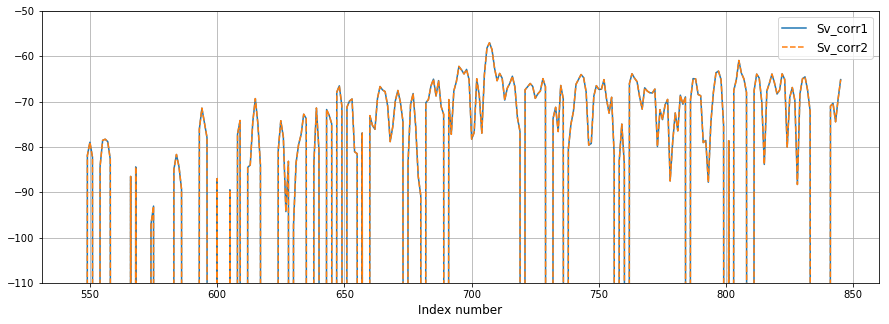

In [595]:
ping_idx = 16789
plt.figure(figsize=(15,5))
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr_method1[-500:-200,ping_idx],label='Sv_corr1')
plt.plot(np.arange(power_data.shape[0])[-500:-200],Sv_corr_method2[-500:-200,ping_idx],'--',label='Sv_corr2')
plt.ylim([-110,-50])
plt.grid()
plt.xlabel('Index number',fontsize=12)
plt.legend(fontsize=12)

Comparison looks good. The function is ready for use.

Check now Sv_noise looks like:

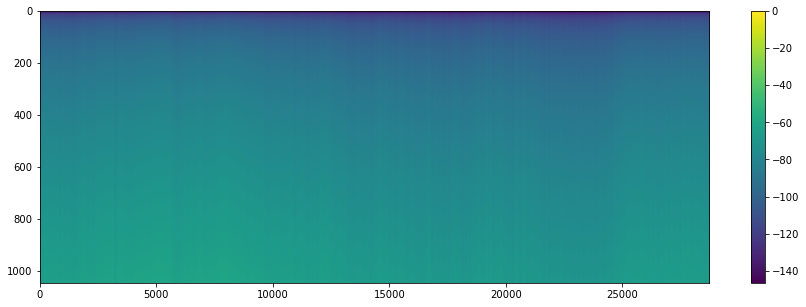

In [598]:
plt.figure(figsize=(15,5))
plt.imshow(Sv_noise,aspect='auto')
plt.colorbar()

Above was checking data from 20150910. Below use the same function to check data from 20170910.

First checking 120 kHz results:

In [603]:
cal_params = get_cal_params(power_data_dict2,particle_data2,config_header2,config_transducer2)
noise_est = get_noise(power_data_dict2[1],bin_size2,ping_bin_range=40,depth_bin_range=10)

In [608]:
Sv_raw,Sv_noise,Sv_corr_method1,Sv_corr_method2 = remove_noise(power_data_dict2[1],cal_params[0],noise_est,ping_bin_range=40,tvg_correction_factor=2)

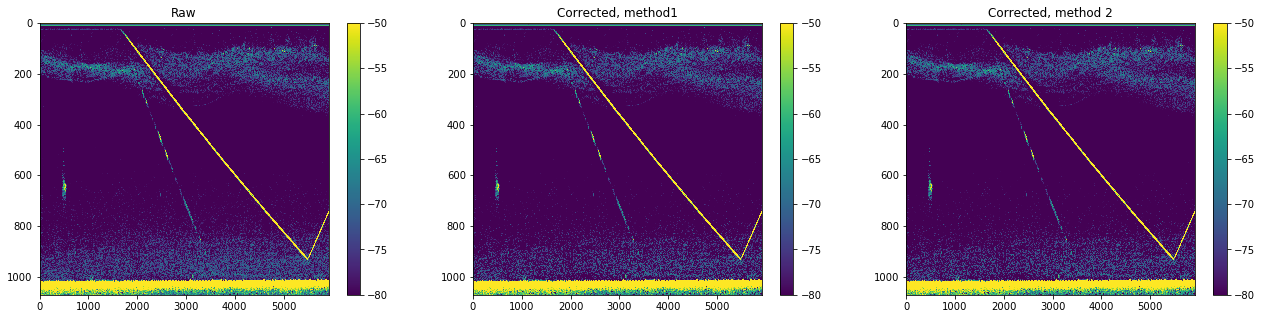

In [609]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_method1,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr_method2,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

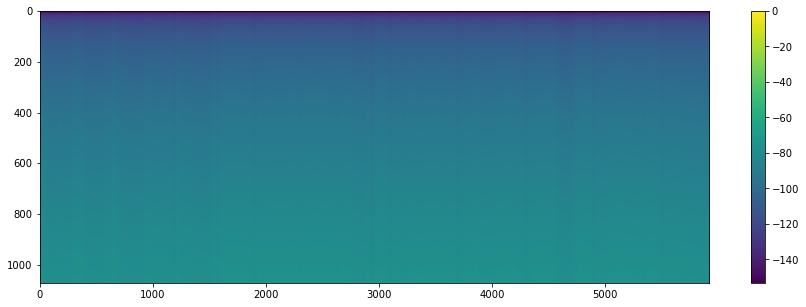

In [610]:
plt.figure(figsize=(15,5))
plt.imshow(Sv_noise,aspect='auto')
plt.colorbar()

Results look nice, although near the surface (bottom part of the figure panels) there are spurious noise-like response. Not sure if those are noise are actually scatterers...

Now take a look at 200 kHz results:

In [614]:
noise_est = get_noise(power_data_dict2[3],bin_size2,ping_bin_range=40,depth_bin_range=10)
Sv_raw_200,Sv_noise_200,Sv_corr_method1_200,Sv_corr_method2_200 = remove_noise(power_data_dict2[3],cal_params[2],noise_est,ping_bin_range=40,tvg_correction_factor=2)

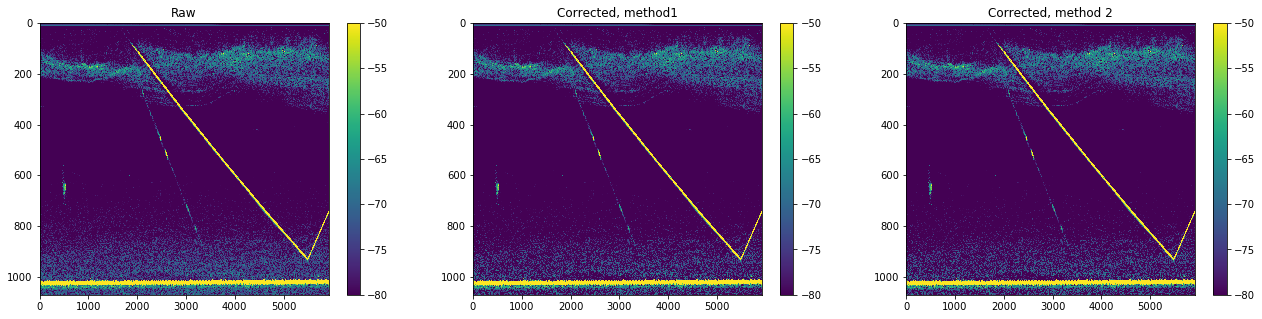

In [615]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_method1_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr_method2_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

As well as 38 kHz results:

In [616]:
noise_est = get_noise(power_data_dict2[2],bin_size2,ping_bin_range=40,depth_bin_range=10)
Sv_raw_38,Sv_noise_38,Sv_corr_method1_38,Sv_corr_method2_38 = remove_noise(power_data_dict2[2],cal_params[1],noise_est,ping_bin_range=40,tvg_correction_factor=2)

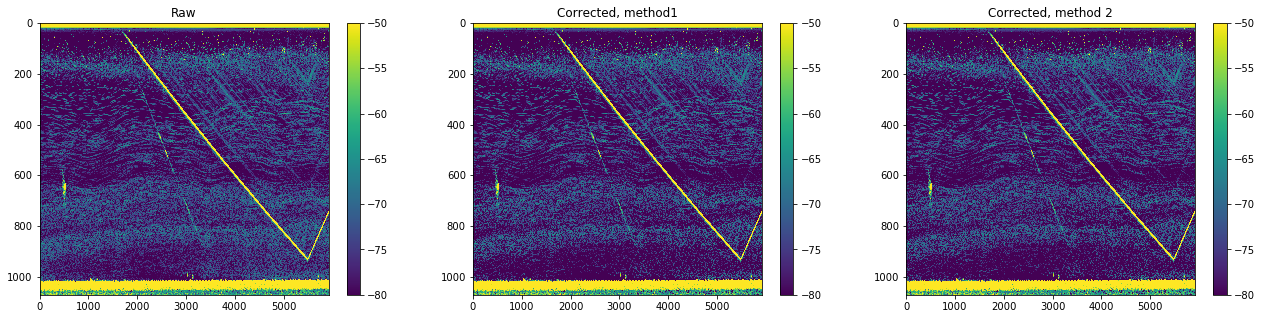

In [617]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_method1_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected, method1')
im2 = ax2.imshow(Sv_corr_method2_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Corrected, method 2')

Try plotting all 3 frequencies together.

First the corrected data:

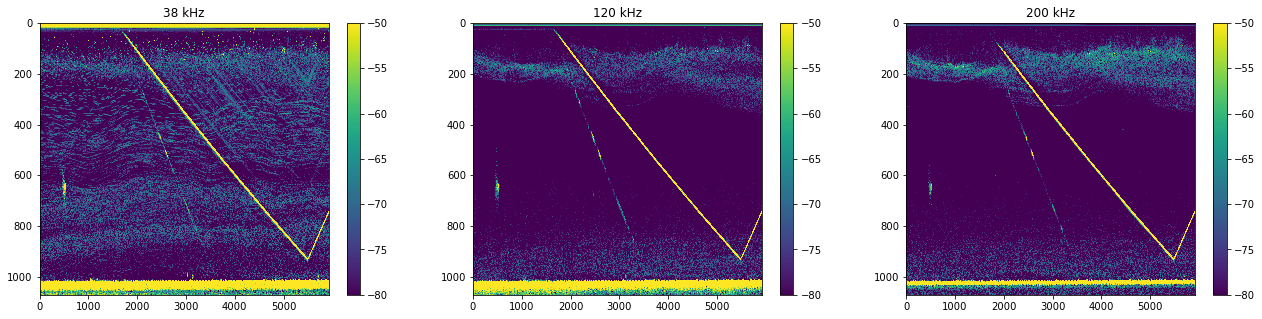

In [620]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_method1_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_corr_method1,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_corr_method1_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

And then the raw data:

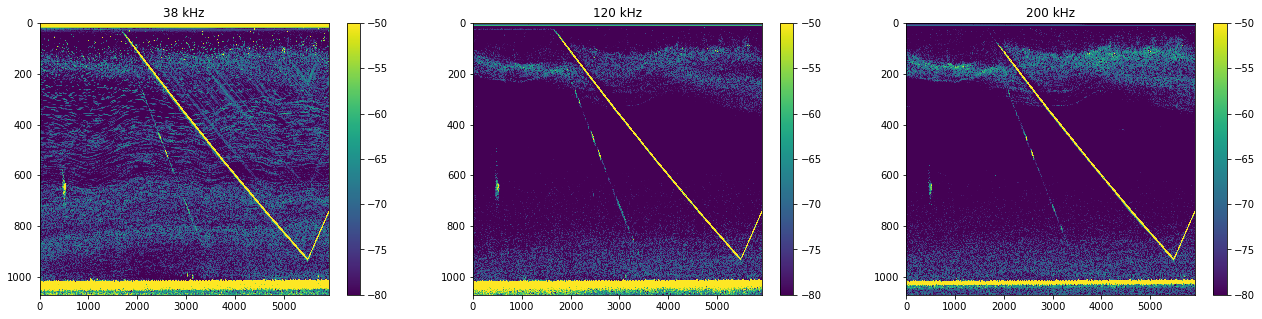

In [621]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_raw_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')